### Resource

- [google drive](https://drive.google.com/drive/u/1/folders/1N15PTA1y0ou5YyPDUN-MdlTGPXq3Rxhc)
- [iowa liquor dataset](https://console.cloud.google.com/bigquery?authuser=1&invt=AbtrQg&project=solid-dominion-452916-p4&supportedpurview=project&ws=!1m5!1m4!4m3!1sbigquery-public-data!2siowa_liquor_sales!3ssales)
- [iowa population by county](https://data.iowa.gov/Community-Demographics/County-Population-in-Iowa-by-Year/qtnr-zsrc/about_data)
- [iowa population by city](https://data.iowa.gov/Community-Demographics/Iowa-Population-by-City-ACS-5-Year-Estimates-/26ad-icvy/about_data)
- [iowa income](https://data.iowa.gov/Economic-Statistics/Annual-Personal-Income-for-State-of-Iowa-by-County/st2k-2ti2/about_data)
- [iowa fuel sales](https://data.iowa.gov/Sales-Distribution/Iowa-Motor-Fuel-Sales-by-County-and-Year/hbwp-wys3/about_data)
- [iowa excessive drinking](https://www.countyhealthrankings.org/health-data/community-conditions/health-infrastructure/health-promotion-and-harm-reduction/excessive-drinking?state=19&tab=1&year=2025)

### Packages

In [2]:
import pandas_gbq
from google.oauth2 import service_account
import pandas as pd
import plotnine as p9
from sodapy import Socrata

# 1. Load Data

In [3]:
SERVICE_ACCOUNT_FILE = 'secret/service_account_key.json'
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

sql = """
SELECT 
    date,
    store_name,
    city,
    county,
    item_description,
    state_bottle_cost,
    state_bottle_retail,
    bottles_sold,
    sale_dollars,
    volume_sold_liters
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date>='2024-01-01' AND date<'2025-01-01' AND state_bottle_cost>0 AND state_bottle_retail>0
AND bottles_sold>0
"""

df_google_cloud = pandas_gbq.read_gbq(sql, credentials=credentials)

Downloading: 100%|██████████|


In [1]:
df_google = df_google_cloud.copy()
df_google['gross_profit'] = (
    (df_google['state_bottle_retail'] - df_google['state_bottle_cost']) * df_google['bottles_sold']
)
df_google.rename(columns={
    'store_name': 'store',
    'item_description': 'item',
    'bottles_sold': 'bottles',
}, inplace=True)
df_google.columns = df_google.columns.str.lower()
df_google['store'] = df_google['store'].str.lower()
df_google['city'] = df_google['city'].str.lower()
df_google['county'] = df_google['county'].str.lower()
df_google['item'] = df_google['item'].str.lower()
df_google

NameError: name 'df_google_cloud' is not defined

In [128]:
print("The earliest date:", df_google['date'].min())
print("The latest date:", df_google['date'].max())
print("# of stores:", df_google['store'].nunique())
print("# of cities:", df_google['city'].nunique())
print("# of counties:", df_google['county'].nunique())
print("# of items:", df_google['item'].nunique())

The earliest date: 2024-01-01
The latest date: 2024-12-31
# of stores: 2151
# of cities: 471
# of counties: 99
# of items: 4515


## 1-1. Liquor Stores

In [95]:
df_store = (
    df_google
    .groupby(['store', 'city', 'county', 'date', 'item'])
    .agg({
        'bottles': 'sum',
        'gross_profit': 'sum',
    })
    .reset_index()
)
df_store

,store,city,county,date,item,bottles,gross_profit
0,'da booze barn / west bend,west bend,palo alto,2024-01-04,99 fruits mini,1,25.8
1,'da booze barn / west bend,west bend,palo alto,2024-01-04,barton vodka,6,21.18
2,'da booze barn / west bend,west bend,palo alto,2024-01-04,cabo wabo blanco,6,63.0
3,'da booze barn / west bend,west bend,palo alto,2024-01-04,canadian ltd whisky,6,30.0
4,'da booze barn / west bend,west bend,palo alto,2024-01-04,captain morgan original spiced mini,1,2.4
...,...,...,...,...,...,...,...
2349070,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,canadian ltd whisky,24,27.12
2349071,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,crown royal,12,105.0
2349072,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey,102,298.08
2349073,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey mini dispenser,1,12.9


In [115]:
print('Summary of bottles:\n', df_store['bottles'].describe())
print()
print('Summary of gross profit:\n', df_store['gross_profit'].describe())

Summary of bottles:
 count    2349075.0
mean     13.360109
std      38.253847
min         -456.0
25%            3.0
50%            6.0
75%           12.0
max        13230.0
Name: bottles, dtype: Float64

Summary of gross profit:
 count     2349075.0
mean      63.473408
std      225.471208
min         -1470.0
25%            18.0
50%            33.0
75%           62.04
max         87273.0
Name: gross_profit, dtype: Float64


## 1-2. Population

In [116]:
df_pop_city = pd.read_csv('https://mydata.iowa.gov/resource/26ad-icvy.csv')
df_pop_city.columns = df_pop_city.columns.str.lower()
df_pop_city.rename(columns={
    'name': 'city',
    'value': 'pop_city',
    'data_collection_period': 'year'
}, inplace=True)
df_pop_city['city'] = df_pop_city['city'].str[:-6]
df_pop_city['city'] = df_pop_city['city'].str.lower()
df_pop_city['year'] = df_pop_city['year'].str[-4:]
df_pop_city = df_pop_city[['city', 'year', 'pop_city']]
df_pop_city = df_pop_city[df_pop_city['year']=='2022']
df_pop_city['pop_city'] = df_pop_city['pop_city'].astype(int)
df_pop_city = df_pop_city[['city', 'pop_city']]
df_pop_city

,city,pop_city
0,ackley,1699
1,ackworth,106
2,adair,828
3,adel,6090
4,afton,1105
...,...,...
936,yale,316
937,yetter,16
938,yorktown,35
939,zearing,655


In [117]:
df_pop_county = pd.read_csv('data/iowa_population_county.csv')
df_pop_county.columns = df_pop_county.columns.str.lower()
df_pop_county.rename(columns={
    'population': 'pop_county'
}, inplace=True)
df_pop_county['year'] = df_pop_county['year'].str[-4:]
df_pop_county['county'] = df_pop_county['county'].str[:-7]
df_pop_county['county'] = df_pop_county['county'].str.lower()
df_pop_county = df_pop_county[['county', 'year', 'pop_county']]
df_pop_county = df_pop_county[df_pop_county['year']=='2023']
df_pop_county

,county,year,pop_county
35,poweshiek,2023,18453
134,jefferson,2023,15440
158,chickasaw,2023,11658
242,mitchell,2023,10518
245,wright,2023,12656
...,...,...,...
3191,webster,2023,36485
3255,plymouth,2023,25722
3288,fayette,2023,19210
3328,jasper,2023,37919


## 1-3. Income

In [55]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("st2k-2ti2",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_income = pd.DataFrame.from_records(df_list)

df_income['date'] = df_income['date'].str[:4]
df_income = df_income[
    (df_income['date']=='2022') & 
    (df_income['variable']=='Per capita personal income')
    ]
df_income.rename(columns={
    'name': 'county',
    'date': 'year',
    'value': 'annual_income',
}, inplace=True)
df_income['county'] = df_income['county'].str.lower()
df_income = df_income[['county', 'year', 'annual_income']]
df_income['annual_income'] = pd.to_numeric(df_income['annual_income'], errors='coerce')
df_income

,county,year,annual_income
51,adair,2022,67668
103,adams,2022,67657
155,allamakee,2022,55015
207,appanoose,2022,47779
259,audubon,2022,69105
...,...,...,...
4939,winnebago,2022,55013
4991,winneshiek,2022,61042
5043,woodbury,2022,51029
5095,worth,2022,55418


## 1-4. Fuel Sales

In [158]:
client = Socrata("data.iowa.gov", None)
df_list = []
offset = 0

while True:
    results = client.get("hbwp-wys3",
                         limit = 1000,
                         offset = offset)
    offset = offset + 1000
    df_list.extend(results)

    if len(results) < 1000:
        break

df_fuel = pd.DataFrame.from_records(df_list)
df_fuel.rename(columns={
    'calendar_year': 'year',
    # 'number_of_retail_locations': 'locations',
    'non_ethanol_gas_sales': 'gas_sales',
}, inplace=True)
df_fuel = df_fuel[df_fuel['year']=='2024']
df_fuel['county'] = df_fuel['county'].str.lower()
df_fuel = df_fuel[['county', 'gas_sales']]
df_fuel

,county,gas_sales
1174,adair,895851
1175,adams,188155
1176,allamakee,923224
1177,appanoose,792131
1178,audubon,226034
...,...,...
1268,winnebago,582020
1269,winneshiek,976372
1270,woodbury,7032420
1271,worth,445045


## 1-5. Excessive Drinking

In [164]:
df_drinking = pd.read_csv('data/iowa_excessive_drinking.csv')
df_drinking.columns = df_drinking.columns.str.lower()
df_drinking.rename(columns={
    'county value**': 'excessive_drinking_percent',
}, inplace=True)
df_drinking['county'] = df_drinking['county'].str.lower()
df_drinking['excessive_drinking_percent'] = df_drinking['excessive_drinking_percent'].str[:2]
df_drinking = df_drinking[['county', 'excessive_drinking_percent']]
df_drinking

,county,excessive_drinking_percent
0,iowa,25
1,adair,24
2,adams,25
3,allamakee,23
4,appanoose,23
...,...,...
95,winnebago,24
96,winneshiek,27
97,woodbury,25
98,worth,25


# 2. Exploere Data

## 2-1. Data Frame

In [173]:
df_county = pd.merge(df_pop_county, df_income, on='county', how='left')
df_county = pd.merge(df_county, df_fuel, on='county', how='left')
df_county = pd.merge(df_county, df_drinking, on='county', how='left')
df_county = df_county[['county', 'pop_county', 'annual_income', 'gas_sales', 'excessive_drinking_percent']]
df = pd.merge(df_store, df_pop_city, on='city', how='left')
df = pd.merge(df, df_county, on='county', how='left')
df['pop_city'] = df['pop_city'].astype('Int64')
df['gas_sales'] = df['gas_sales'].astype(int)
df['excessive_drinking_percent'] = df['excessive_drinking_percent'].astype(int)
df

,store,city,county,date,item,bottles,gross_profit,pop_city,pop_county,annual_income,gas_sales,excessive_drinking_percent
0,'da booze barn / west bend,west bend,palo alto,2024-01-04,99 fruits mini,1,25.8,936,8810,65080,306384,26
1,'da booze barn / west bend,west bend,palo alto,2024-01-04,barton vodka,6,21.18,936,8810,65080,306384,26
2,'da booze barn / west bend,west bend,palo alto,2024-01-04,cabo wabo blanco,6,63.0,936,8810,65080,306384,26
3,'da booze barn / west bend,west bend,palo alto,2024-01-04,canadian ltd whisky,6,30.0,936,8810,65080,306384,26
4,'da booze barn / west bend,west bend,palo alto,2024-01-04,captain morgan original spiced mini,1,2.4,936,8810,65080,306384,26
...,...,...,...,...,...,...,...,...,...,...,...,...
2361287,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,canadian ltd whisky,24,27.12,690,14396,66517,529531,24
2361288,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,crown royal,12,105.0,690,14396,66517,529531,24
2361289,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey,102,298.08,690,14396,66517,529531,24
2361290,yesway store #1198 / swea city,swea city,kossuth,2024-12-18,fireball cinnamon whiskey mini dispenser,1,12.9,690,14396,66517,529531,24


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2361292 entries, 0 to 2361291
Data columns (total 12 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   store                       object 
 1   city                        object 
 2   county                      object 
 3   date                        dbdate 
 4   item                        object 
 5   bottles                     Int64  
 6   gross_profit                Float64
 7   pop_city                    Int64  
 8   pop_county                  int64  
 9   annual_income               int64  
 10  gas_sales                   int64  
 11  excessive_drinking_percent  int64  
dtypes: Float64(1), Int64(2), dbdate(1), int64(4), object(4)
memory usage: 222.9+ MB


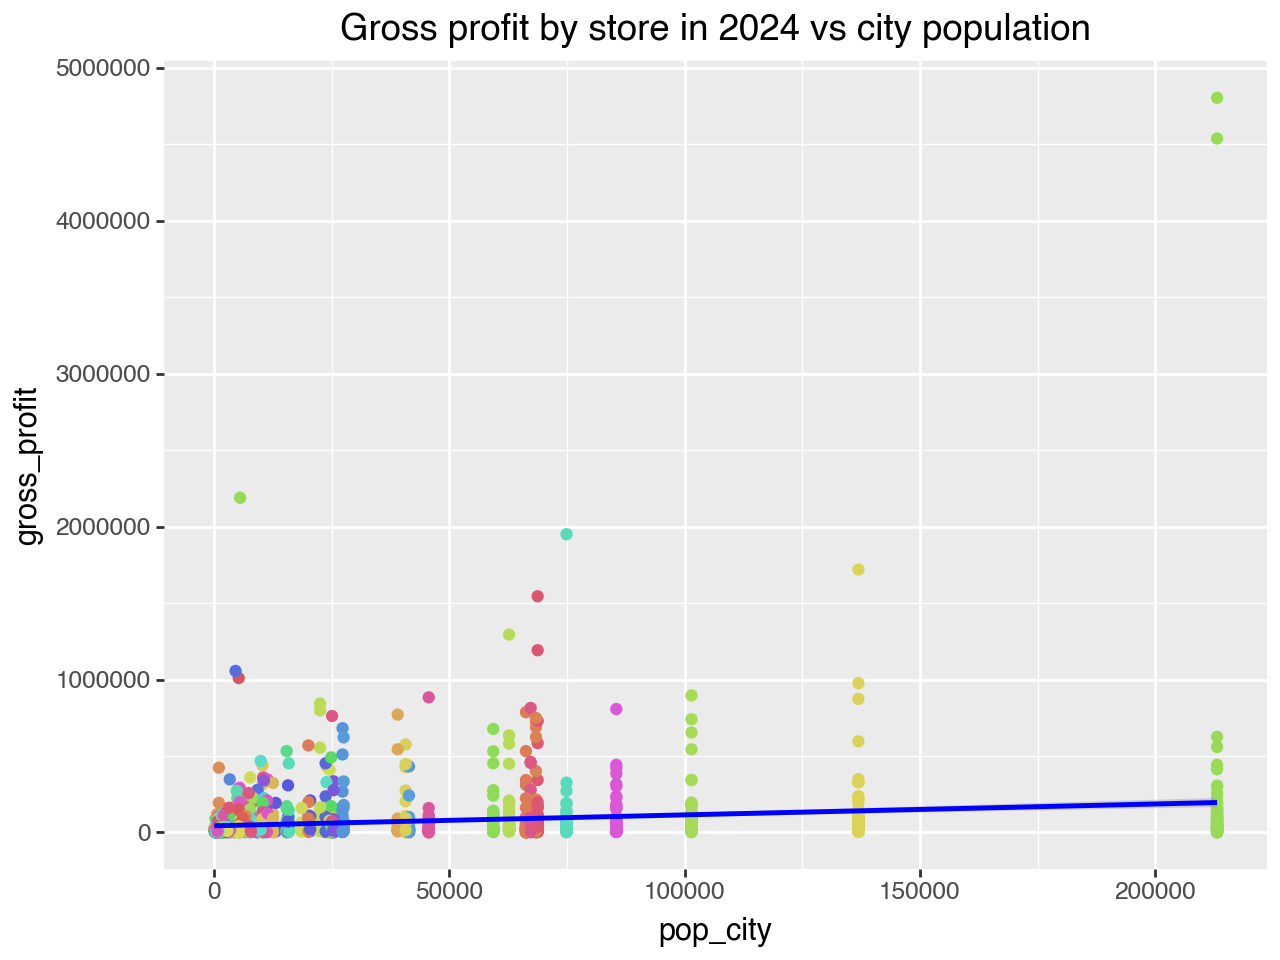

In [132]:
df_store_pop = df.groupby(['store', 'pop_city', 'city'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_pop, p9.aes(x='pop_city', y='gross_profit', color='city')) +
    p9.geom_point() +
    p9.geom_smooth(color='blue') +
    p9.labs(title='Gross profit by store in 2024 vs city population') +
    p9.theme(legend_position='none')
)
plot

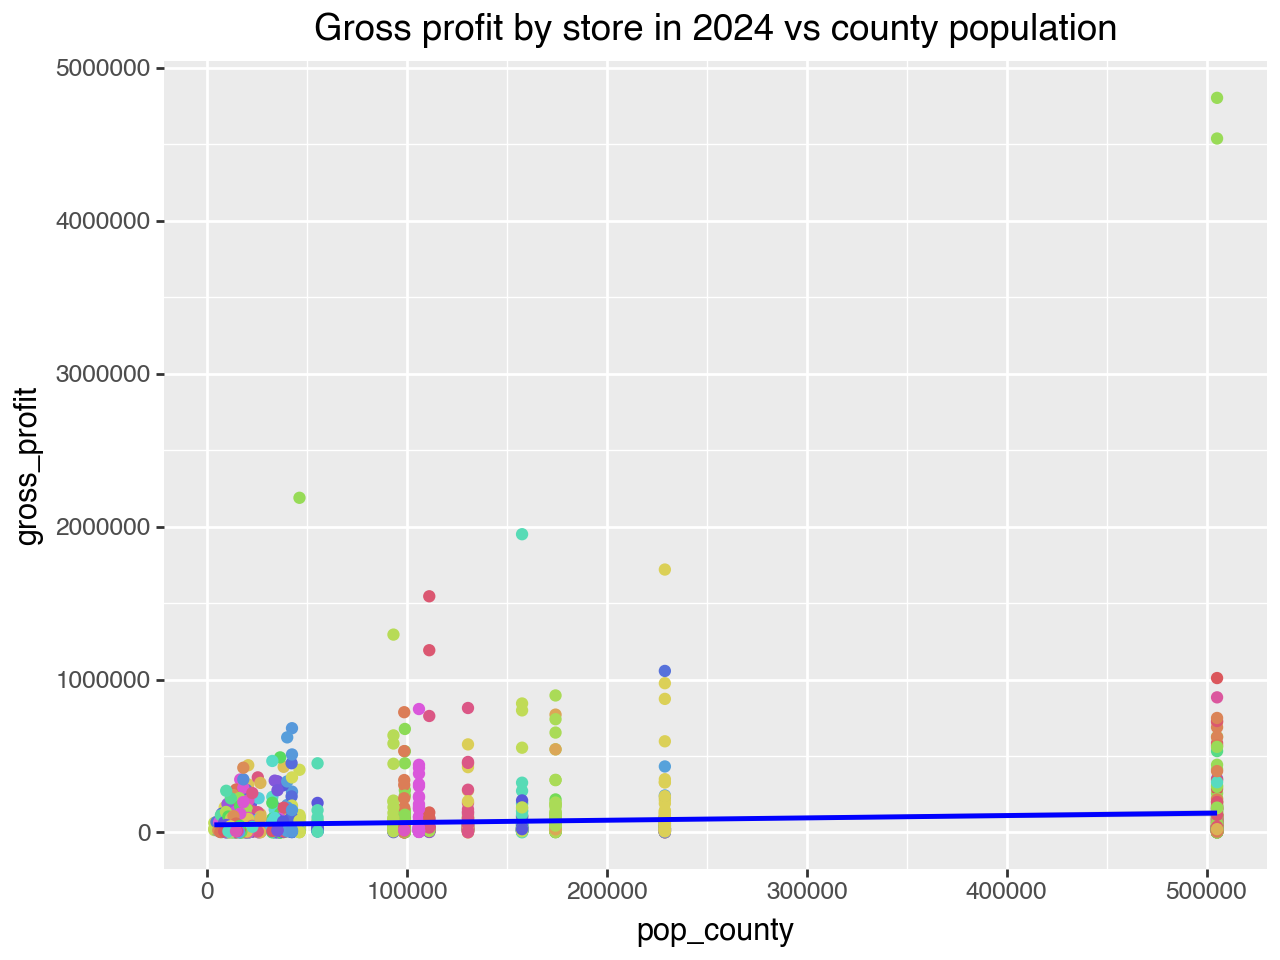

In [134]:
df_store_pop_county = df.groupby(['store', 'pop_county', 'city'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_pop_county, p9.aes(x='pop_county', y='gross_profit', color='city')) +
    p9.geom_point() +
    p9.geom_smooth(color='blue') +
    p9.labs(title='Gross profit by store in 2024 vs county population') +
    p9.theme(legend_position='none')
)
plot

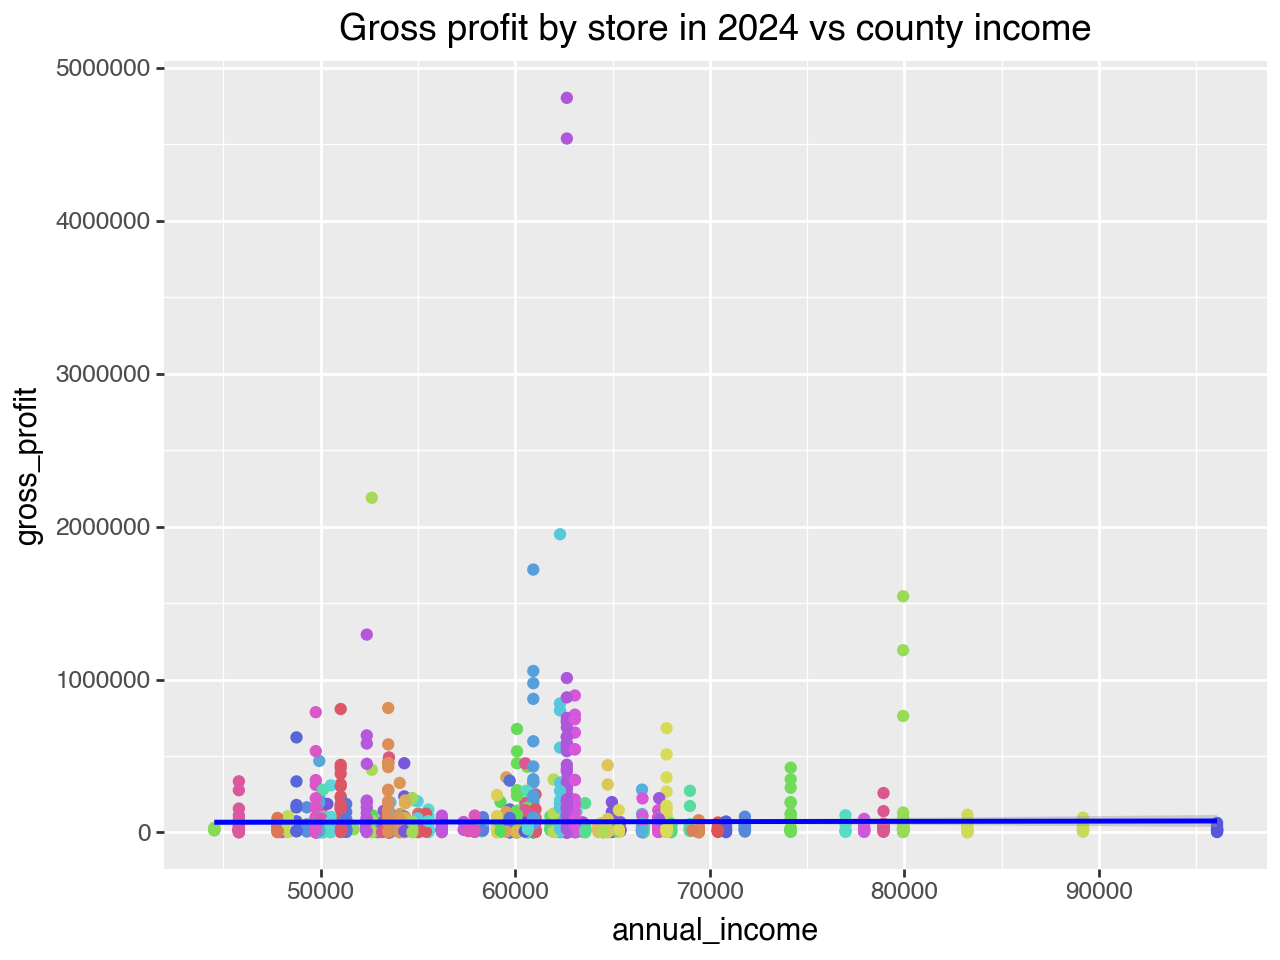

In [136]:
df_store_income = df.groupby(['store', 'annual_income', 'county'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_store_income, p9.aes(x='annual_income', y='gross_profit', color='county')) +
    p9.geom_point() +
    p9.geom_smooth(color='blue') +
    p9.labs(title='Gross profit by store in 2024 vs county income') +
    p9.theme(legend_position='none')
)
plot

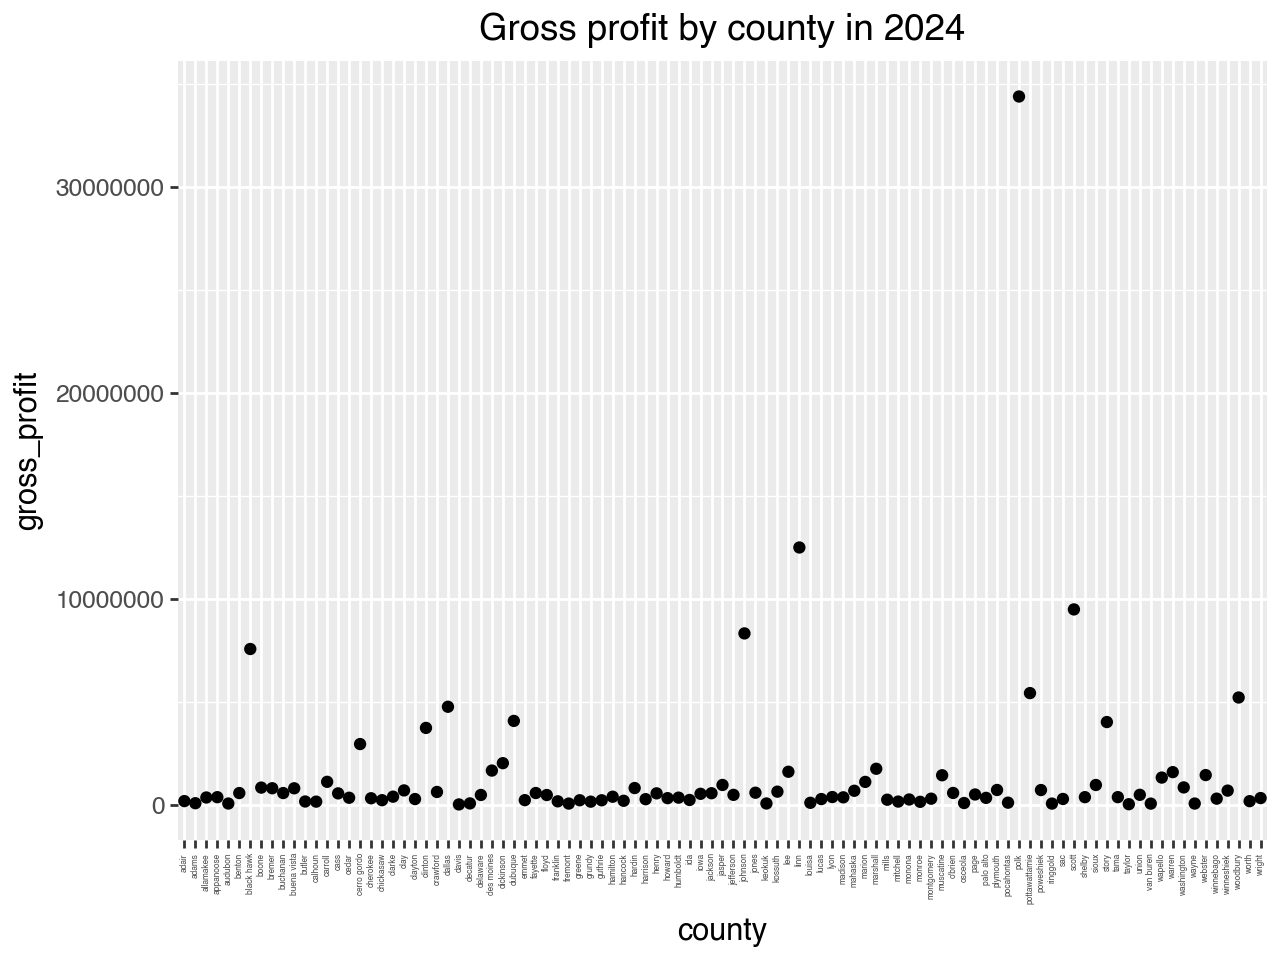

In [127]:
df_county_profit = df.groupby(['county'])['gross_profit'].sum().reset_index(name='gross_profit')
plot = (
    p9.ggplot(df_county_profit, p9.aes(x='county', y='gross_profit')) +
    p9.geom_point() +
    p9.labs(title='Gross profit by county in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=3))
)
plot

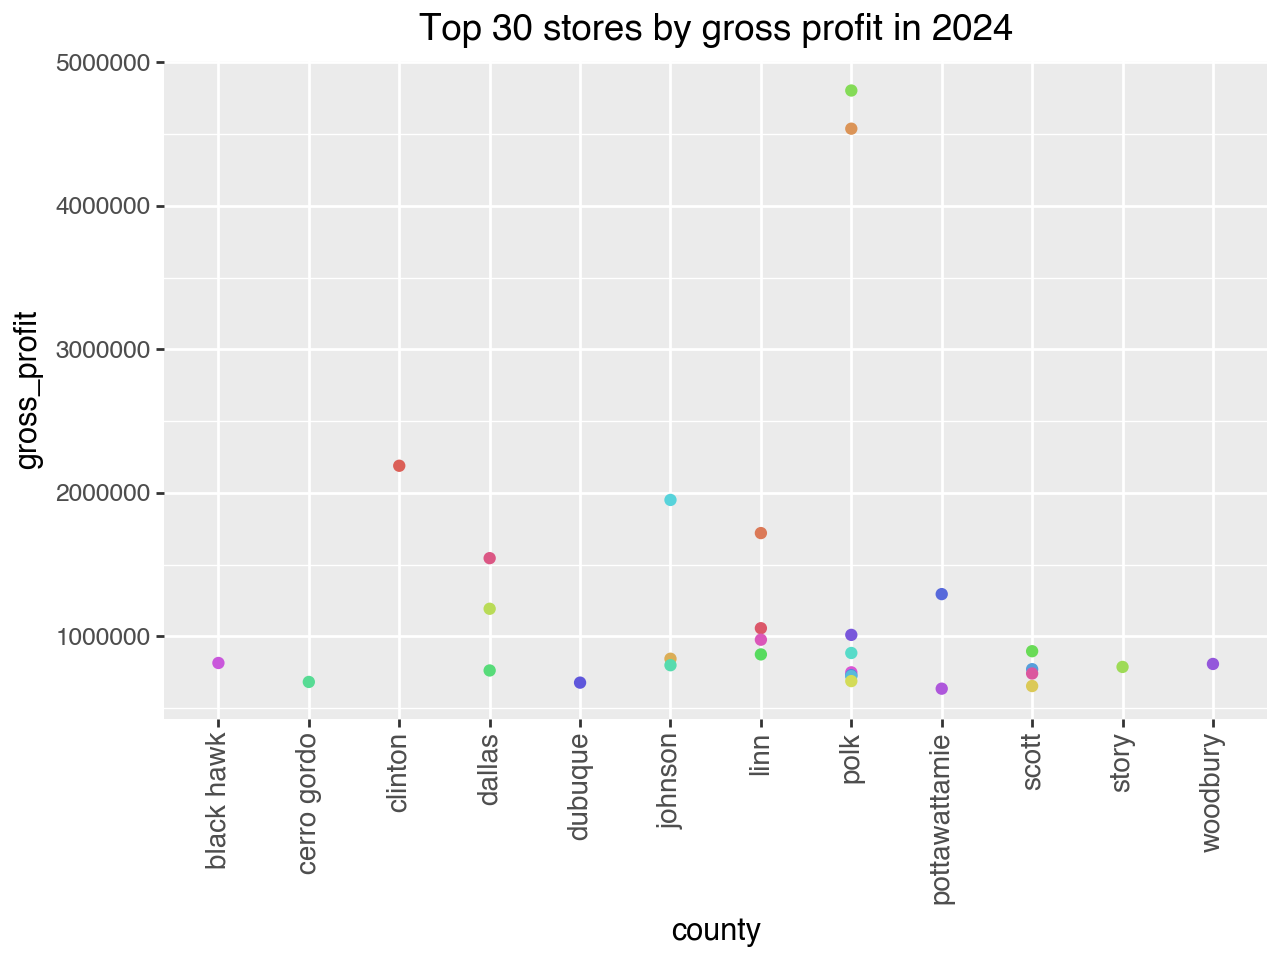

In [150]:
df_top_store = df.groupby(['store', 'city', 'county'])['gross_profit'].sum().reset_index(name='gross_profit')
df_top_store = df_top_store.nlargest(30, 'gross_profit')
plot = (
    p9.ggplot(df_top_store, p9.aes(x='county', y='gross_profit', color='store')) +
    p9.geom_point() +
    p9.labs(title='Top 30 stores by gross profit in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=10),
             legend_position='none')
)
plot

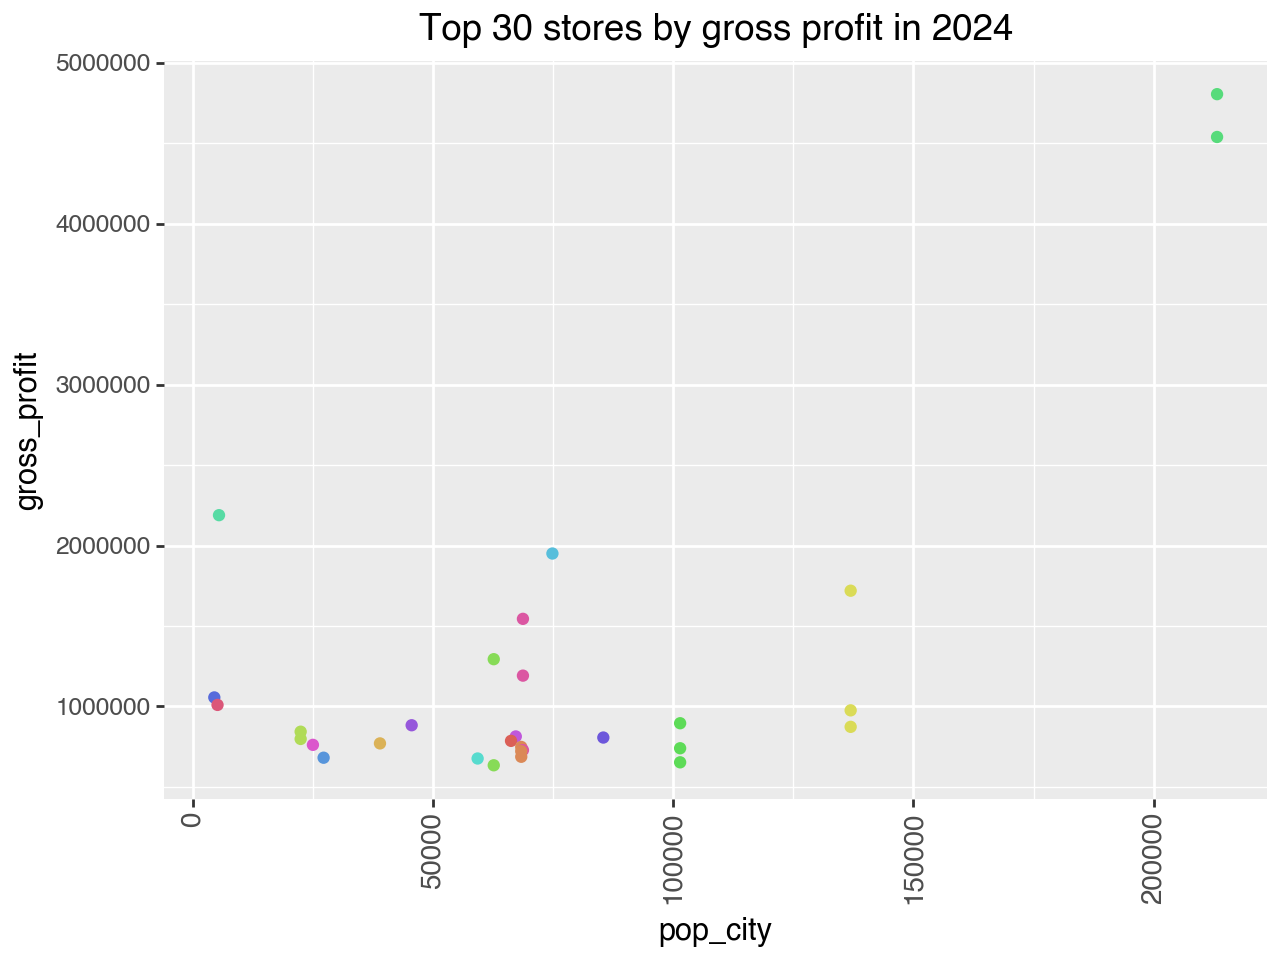

In [155]:
df_top_store = df.groupby(['store', 'city', 'county', 'pop_city'])['gross_profit'].sum().reset_index(name='gross_profit')
df_top_store = df_top_store.nlargest(30, 'gross_profit')
plot = (
    p9.ggplot(df_top_store, p9.aes(x='pop_city', y='gross_profit', color='city')) +
    p9.geom_point() +
    p9.labs(title='Top 30 stores by gross profit in 2024') +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=10),
             legend_position='none')
)
plot